In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

### Load mall customers data

In [2]:
data = pd.read_csv('./data/mall_customers.csv')
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


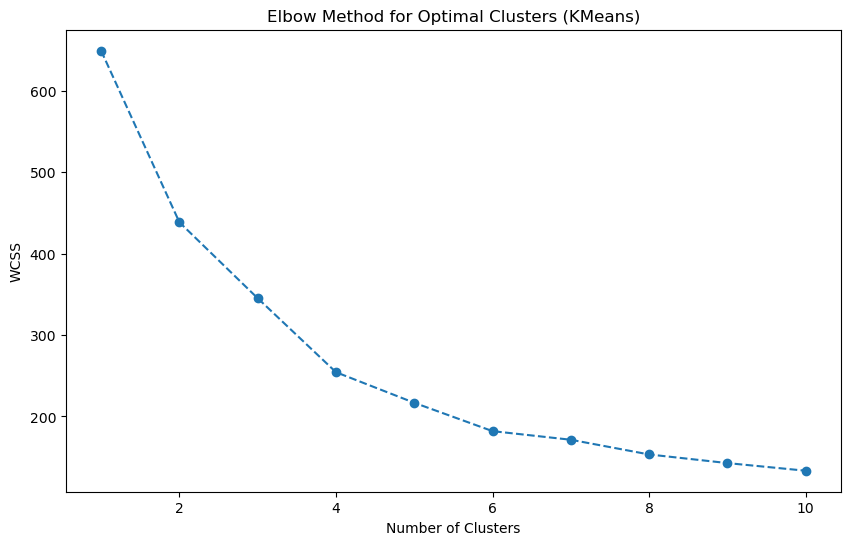

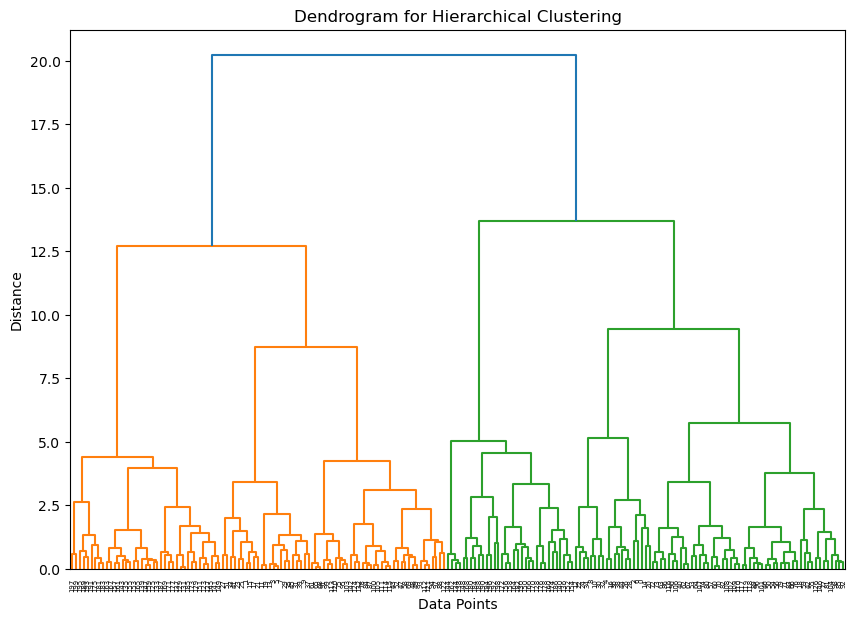

In [3]:
# Drop the 'CustomerID' since it is just an identifier and won't be useful for clustering
X = df.drop(columns=['CustomerID'])

# Step 1: Encoding categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Ensure dense output
X_encoded = encoder.fit_transform(X[['Gender']])

# Step 2: Scaling numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Combine scaled numerical and encoded categorical features
X_preprocessed = np.hstack([X_scaled, X_encoded])

# Step 3: Elbow method for KMeans
def elbow_method(X, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Clusters (KMeans)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Step 4: Hierarchical Clustering with Dendrogram
def plot_dendrogram(X):
    linked = linkage(X, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.title('Dendrogram for Hierarchical Clustering')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.show()

# Elbow method for KMeans
elbow_method(X_preprocessed, max_clusters=10)

# Hierarchical Clustering Dendrogram
plot_dendrogram(X_preprocessed)


In [4]:
df.sample(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
65,66,Male,18,48,59
154,155,Female,47,78,16
166,167,Male,42,86,20
45,46,Female,24,39,65
122,123,Female,40,69,58


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
# Fit KMeans with a specified number of clusters
n_clusters = 4  # Adjust based on your elbow method results
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_preprocessed)

# Assign cluster labels to a new column in the DataFrame
df['Cluster'] = kmeans.labels_

# Step 3: Stratification based on cluster labels
def stratify_based_on_cluster(cluster_label):
    if cluster_label == 0:
        return 'Group 1'
    elif cluster_label == 1:
        return 'Group 2'
    elif cluster_label == 2:
        return 'Group 3'
    else:
        return 'Group 4'

# Apply the stratification function
df['stratification'] = df['Cluster'].apply(stratify_based_on_cluster)

# Display the updated DataFrame with stratification
print(df[['CustomerID', 'Cluster', 'stratification']])

     CustomerID  Cluster stratification
0             1        2        Group 3
1             2        2        Group 3
2             3        2        Group 3
3             4        2        Group 3
4             5        2        Group 3
..          ...      ...            ...
195         196        1        Group 2
196         197        3        Group 4
197         198        1        Group 2
198         199        3        Group 4
199         200        1        Group 2

[200 rows x 3 columns]


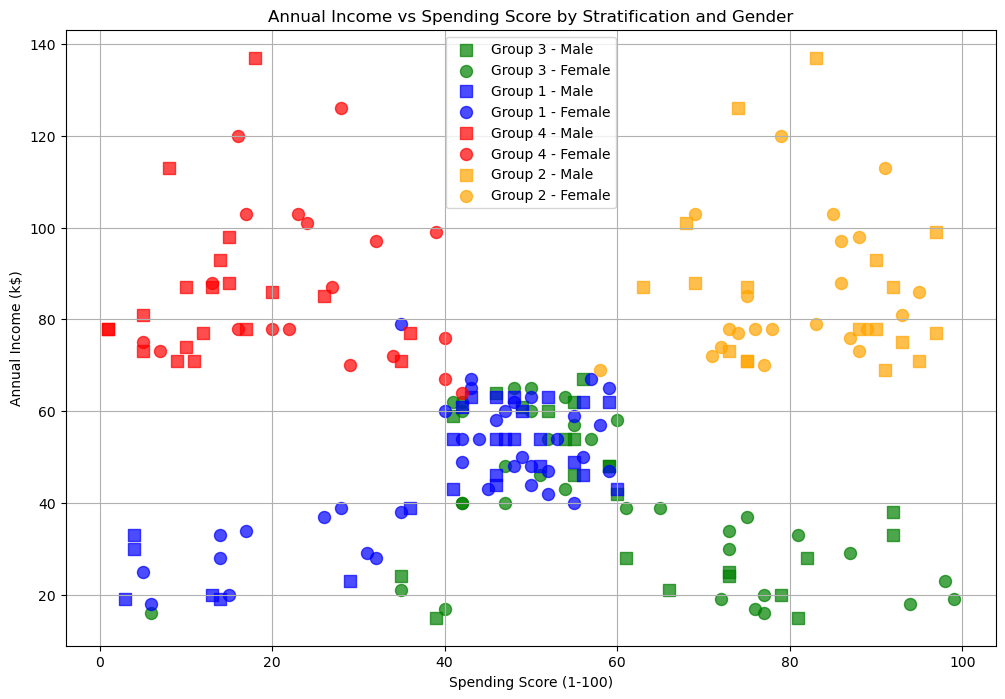

In [7]:
import matplotlib.pyplot as plt

# Define colors and markers for stratification and gender
colors = {'Group 1': 'blue', 'Group 2': 'orange', 'Group 3': 'green', 'Group 4': 'red'}
markers = {'Male': 's', 'Female': 'o'}

# Create a scatter plot
plt.figure(figsize=(12, 8))
for stratification_group in df['stratification'].unique():
    for gender in df['Gender'].unique():
        subset = df[(df['stratification'] == stratification_group) & (df['Gender'] == gender)]
        plt.scatter(subset['Spending Score (1-100)'], 
                    subset['Annual Income (k$)'],
                    label=f'{stratification_group} - {gender}',
                    color=colors[stratification_group],
                    marker=markers[gender],
                    alpha=0.7,
                    s=75
                   )

plt.title('Annual Income vs Spending Score by Stratification and Gender')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid()
plt.show()


In [8]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'Cluster', 'stratification'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
 5   Cluster                 200 non-null    int32 
 6   stratification          200 non-null    object
dtypes: int32(1), int64(4), object(2)
memory usage: 10.3+ KB


In [10]:
clus_pred = df.groupby(['stratification', 'Gender']).mean().T
clus_pred

stratification            Group 1                Group 2              \
Gender                     Female       Male      Female        Male   
CustomerID              69.081081  67.666667  161.500000  160.444444   
Age                     51.405405  57.333333   32.545455   33.277778   
Annual Income (k$)      47.594595  47.000000   85.272727   87.111111   
Spending Score (1-100)  40.567568  40.222222   80.590909   82.666667   
Cluster                  0.000000   0.000000    1.000000    1.000000   

stratification            Group 3                Group 4          
Gender                     Female       Male      Female    Male  
CustomerID              52.294118  55.130435  160.000000  159.50  
Age                     26.000000  24.608696   40.263158   39.50  
Annual Income (k$)      39.529412  40.695652   87.105263   85.15  
Spending Score (1-100)  59.500000  61.478261   24.947368   14.05  
Cluster                  2.000000   2.000000    3.000000    3.00